In [2]:
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon, MultiPolygon, Point
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [ ]:
def calculate_nearest_neighbor_distances(points_gdf):
    """Calculate nearest neighbor distance for each drillhole"""
    from scipy.spatial import cKDTree
    
    coords = np.array(list(zip(points_gdf.geometry.x, points_gdf.geometry.y)))
    tree = cKDTree(coords)
    distances, indices = tree.query(coords, k=2)
    return distances[:, 1]

def calculate_triangle_area(p1, p2, p3):
    """Calculate area of a triangle given three points"""
    v1 = p2 - p1
    v2 = p3 - p1
    area = 0.5 * abs(np.cross(v1, v2))
    return area

def is_valid_triangle(p1, p2, p3, max_area, max_edge, edge_tolerance=1.5):
    """
    Check if a triangle is valid based on area and edge constraints.
    Uses flexible edge rules: at least 2 edges <= max_edge, longest <= max_edge * tolerance
    """
    # Check area constraint
    area = calculate_triangle_area(p1, p2, p3)
    if area > max_area:
        return False
    
    # Calculate edge lengths
    edge1 = np.linalg.norm(p2 - p1)
    edge2 = np.linalg.norm(p3 - p2)
    edge3 = np.linalg.norm(p1 - p3)
    edges = sorted([edge1, edge2, edge3])
    
    # At least 2 edges must be within max_edge
    if edges[0] <= max_edge and edges[1] <= max_edge:
        # Longest edge can be within tolerance (for diagonals)
        if edges[2] <= max_edge * edge_tolerance:
            return True
    
    return False

def find_triangle_based_clusters(points_gdf, max_distance, max_area, min_drillholes=4, edge_tolerance=1.5):
    """
    Find clusters using triangle connectivity (same as previous concept).
    
    This ensures proper clustering based on valid triangle connections,
    not just distance.
    """
    coords = np.array(list(zip(points_gdf.geometry.x, points_gdf.geometry.y)))
    n_points = len(coords)
    
    if n_points < min_drillholes:
        return np.full(n_points, -1)
    
    # Create Delaunay triangulation
    tri = Delaunay(coords)
    
    # Find valid triangles based on area and edge constraints
    valid_triangle_indices = []
    for simplex in tri.simplices:
        p1, p2, p3 = coords[simplex]
        if is_valid_triangle(p1, p2, p3, max_area, max_distance, edge_tolerance):
            valid_triangle_indices.append(simplex)
    
    if not valid_triangle_indices:
        return np.full(n_points, -1)
    
    # Build adjacency matrix from valid triangles
    adjacency = np.zeros((n_points, n_points), dtype=int)
    for simplex in valid_triangle_indices:
        adjacency[simplex[0], simplex[1]] = 1
        adjacency[simplex[1], simplex[0]] = 1
        adjacency[simplex[0], simplex[2]] = 1
        adjacency[simplex[2], simplex[0]] = 1
        adjacency[simplex[1], simplex[2]] = 1
        adjacency[simplex[2], simplex[1]] = 1
    
    # Find connected components
    graph = csr_matrix(adjacency)
    n_components, labels = connected_components(csgraph=graph, directed=False)
    
    # Filter clusters by minimum size
    valid_labels = labels.copy()
    for cluster_id in range(n_components):
        cluster_size = np.sum(labels == cluster_id)
        if cluster_size < min_drillholes:
            valid_labels[labels == cluster_id] = -1
    
    # Renumber valid clusters
    unique_valid = np.unique(valid_labels[valid_labels >= 0])
    label_map = {old: new for new, old in enumerate(unique_valid)}
    label_map[-1] = -1
    final_labels = np.array([label_map[label] for label in valid_labels])
    
    return final_labels

def alpha_shape(points, alpha_radius):
    """
    Create alpha shape (concave hull) from points using alpha parameter.
    """
    if len(points) < 3:
        return MultiPoint(points).convex_hull
    
    tri = Delaunay(points)
    
    def circumradius(p1, p2, p3):
        a = np.linalg.norm(p2 - p1)
        b = np.linalg.norm(p3 - p2)
        c = np.linalg.norm(p1 - p3)
        area = 0.5 * abs(np.cross(p2 - p1, p3 - p1))
        if area < 1e-10:
            return float('inf')
        return (a * b * c) / (4.0 * area)
    
    valid_triangles = []
    for simplex in tri.simplices:
        p1, p2, p3 = points[simplex]
        r = circumradius(p1, p2, p3)
        if r <= alpha_radius:
            triangle = Polygon([p1, p2, p3])
            valid_triangles.append(triangle)
    
    if not valid_triangles:
        return MultiPoint(points).convex_hull
    
    alpha_poly = unary_union(valid_triangles)
    return alpha_poly

def classify_drillholes(drillholes, measured_distance=71, indicated_distance=121, 
                       min_drillholes=4, area_factor=0.6, edge_tolerance=1.5):
    """
    Classify drillholes using triangle-based clustering.
    Categories: Measured, Indicated, Inferred (no Excluded).
    """
    print("\n" + "="*70)
    print("STEP 1: CLASSIFYING DRILLHOLES (Triangle-Based Clustering)")
    print("="*70)
    
    nn_distances = calculate_nearest_neighbor_distances(drillholes)
    drillholes['nn_distance'] = nn_distances
    
    # Initial classification by spacing
    drillholes['category'] = 'Inferred'
    drillholes.loc[nn_distances < indicated_distance, 'category'] = 'Indicated'
    drillholes.loc[nn_distances < measured_distance, 'category'] = 'Measured'
    
    print(f"\nInitial classification by spacing:")
    print(drillholes['category'].value_counts())
    
    # Triangle-based clustering for Measured
    measured_mask = drillholes['category'] == 'Measured'
    measured_clusters = np.full(len(drillholes), -1)
    
    if measured_mask.sum() >= min_drillholes:
        max_area_measured = measured_distance ** 2 * area_factor
        measured_clusters[measured_mask] = find_triangle_based_clusters(
            drillholes[measured_mask], measured_distance, max_area_measured, 
            min_drillholes, edge_tolerance
        )
    
    drillholes['measured_cluster'] = measured_clusters
    
    # Triangle-based clustering for Indicated (includes Measured holes)
    indicated_mask = drillholes['category'].isin(['Measured', 'Indicated'])
    indicated_clusters = np.full(len(drillholes), -1)
    
    if indicated_mask.sum() >= min_drillholes:
        max_area_indicated = indicated_distance ** 2 * area_factor
        indicated_clusters[indicated_mask] = find_triangle_based_clusters(
            drillholes[indicated_mask], indicated_distance, max_area_indicated, 
            min_drillholes, edge_tolerance
        )
    
    drillholes['indicated_cluster'] = indicated_clusters
    
    # Update categories based on triangle cluster validity
    # If not in valid triangle cluster, downgrade category
    drillholes.loc[(drillholes['category'] == 'Measured') & (drillholes['measured_cluster'] == -1), 'category'] = 'Indicated'
    drillholes.loc[(drillholes['category'] == 'Indicated') & (drillholes['indicated_cluster'] == -1), 'category'] = 'Inferred'
    
    # Re-run triangle clustering after downgrade to get correct Indicated clusters
    indicated_mask = drillholes['category'].isin(['Measured', 'Indicated'])
    indicated_clusters = np.full(len(drillholes), -1)
    if indicated_mask.sum() >= min_drillholes:
        max_area_indicated = indicated_distance ** 2 * area_factor
        indicated_clusters[indicated_mask] = find_triangle_based_clusters(
            drillholes[indicated_mask], indicated_distance, max_area_indicated, 
            min_drillholes, edge_tolerance
        )
    drillholes['indicated_cluster'] = indicated_clusters
    drillholes.loc[(drillholes['category'] == 'Indicated') & (drillholes['indicated_cluster'] == -1), 'category'] = 'Inferred'
    
    print(f"\nFinal classification after triangle-based clustering (min {min_drillholes} holes):")
    print(drillholes['category'].value_counts())
    
    # Count valid clusters
    n_measured = len(np.unique(drillholes[drillholes['measured_cluster'] >= 0]['measured_cluster']))
    n_indicated = len(np.unique(drillholes[drillholes['indicated_cluster'] >= 0]['indicated_cluster']))
    
    print(f"\nValid triangle-based clusters:")
    print(f"  Measured: {n_measured} cluster(s)")
    print(f"  Indicated: {n_indicated} cluster(s)")
    
    return drillholes

def generate_alpha_shape_polygons(drillholes, measured_alpha=None, indicated_alpha=None,
                                  measured_buffer=25, indicated_buffer=50):
    """
    Generate resource polygons using alpha shapes from classified drillholes.
    """
    print("\n" + "="*70)
    print("STEP 2: GENERATING ALPHA SHAPE POLYGONS")
    print("="*70)
    
    all_polygons = []
    
    # Process Measured
    measured_valid = drillholes[drillholes['measured_cluster'] >= 0].copy()
    
    if len(measured_valid) > 0:
        if measured_alpha is None:
            measured_alpha = measured_valid['nn_distance'].max() / 2.0
        
        print(f"\nMeasured: {len(measured_valid)} drillholes, alpha={measured_alpha:.1f}m")
        
        for cluster_id in measured_valid['measured_cluster'].unique():
            cluster_holes = measured_valid[measured_valid['measured_cluster'] == cluster_id]
            coords = np.array(list(zip(cluster_holes.geometry.x, cluster_holes.geometry.y)))
            
            alpha_poly = alpha_shape(coords, measured_alpha)
            buffered_poly = alpha_poly.buffer(measured_buffer)
            
            if isinstance(buffered_poly, MultiPolygon):
                for poly in buffered_poly.geoms:
                    all_polygons.append({
                        'geometry': poly,
                        'category': 'Measured',
                        'cluster_id': int(cluster_id),
                        'drillholes': len(cluster_holes)
                    })
            else:
                all_polygons.append({
                    'geometry': buffered_poly,
                    'category': 'Measured',
                    'cluster_id': int(cluster_id),
                    'drillholes': len(cluster_holes)
                })
    
    # Process Indicated
    indicated_valid = drillholes[drillholes['indicated_cluster'] >= 0].copy()
    
    if len(indicated_valid) > 0:
        if indicated_alpha is None:
            indicated_alpha = indicated_valid['nn_distance'].max() / 2.0
        
        print(f"Indicated: {len(indicated_valid)} drillholes, alpha={indicated_alpha:.1f}m")
        
        measured_geoms = [p['geometry'] for p in all_polygons if p['category'] == 'Measured']
        measured_union = unary_union(measured_geoms) if measured_geoms else None
        
        for cluster_id in indicated_valid['indicated_cluster'].unique():
            cluster_holes = indicated_valid[indicated_valid['indicated_cluster'] == cluster_id]
            coords = np.array(list(zip(cluster_holes.geometry.x, cluster_holes.geometry.y)))
            
            alpha_poly = alpha_shape(coords, indicated_alpha)
            buffered_poly = alpha_poly.buffer(indicated_buffer)
            
            if measured_union:
                buffered_poly = buffered_poly.difference(measured_union)
            
            if not buffered_poly.is_empty:
                if isinstance(buffered_poly, MultiPolygon):
                    for poly in buffered_poly.geoms:
                        all_polygons.append({
                            'geometry': poly,
                            'category': 'Indicated',
                            'cluster_id': int(cluster_id),
                            'drillholes': len(cluster_holes)
                        })
                else:
                    all_polygons.append({
                        'geometry': buffered_poly,
                        'category': 'Indicated',
                        'cluster_id': int(cluster_id),
                        'drillholes': len(cluster_holes)
                    })
    
    if not all_polygons:
        return gpd.GeoDataFrame()
    
    result_gdf = gpd.GeoDataFrame(all_polygons, crs=drillholes.crs)
    result_gdf['area_m2'] = result_gdf.geometry.area
    result_gdf['area_ha'] = result_gdf['area_m2'] / 10000
    
    print(f"\nGenerated {len(result_gdf)} polygon(s)")
    print(f"  Measured: {len(result_gdf[result_gdf['category']=='Measured'])}")
    print(f"  Indicated: {len(result_gdf[result_gdf['category']=='Indicated'])}")
    
    return result_gdf

def generate_resource_polygons(gpkg_path, output_path=None,
                               measured_distance=71, indicated_distance=121,
                               measured_alpha=None, indicated_alpha=None,
                               measured_buffer=25, indicated_buffer=50,
                               min_drillholes=4, area_factor=0.6, edge_tolerance=1.5):
    """
    Generate resource polygons using triangle-based classification + alpha shapes.
    
    Parameters:
    -----------
    gpkg_path : str
        Path to input GeoPackage
    output_path : str
        Path to save output
    measured_distance : float
        Max spacing for Measured (default 71m)
    indicated_distance : float
        Max spacing for Indicated (default 121m)
    measured_alpha : float
        Alpha radius for Measured (default = distance/2)
    indicated_alpha : float
        Alpha radius for Indicated (default = distance/2)
    measured_buffer : float
        Buffer for Measured (default 25m)
    indicated_buffer : float
        Buffer for Indicated (default 50m)
    min_drillholes : int
        Min drillholes per cluster (default 4)
    area_factor : float
        Triangle area factor (default 0.6)
    edge_tolerance : float
        Edge tolerance for diagonals (default 1.5)
    """
    print("="*70)
    print("ALPHA SHAPE + TRIANGLE CLUSTERING ALGORITHM")
    print("="*70)
    print(f"\nReading: {gpkg_path}")
    
    drillholes = gpd.read_file(gpkg_path)
    print(f"Loaded: {len(drillholes)} drillholes, CRS: {drillholes.crs}")
    
    # Classify with triangle clustering
    classified = classify_drillholes(
        drillholes, measured_distance, indicated_distance,
        min_drillholes, area_factor, edge_tolerance
    )
    
    # Generate alpha shape polygons
    result_gdf = generate_alpha_shape_polygons(
        classified, measured_alpha, indicated_alpha,
        measured_buffer, indicated_buffer
    )
    
    # Save
    if output_path and not result_gdf.empty:
        print(f"\nSaving to: {output_path}")
        result_gdf.to_file(output_path, driver='GPKG')
        
        drill_out = output_path.replace('.gpkg', '_drillholes.gpkg')
        classified.to_file(drill_out, driver='GPKG')
        print(f"Drillholes: {drill_out}")
    
    # Plot
    if not result_gdf.empty:
        plot_results(classified, result_gdf)
    
    return result_gdf, classified

def plot_results(drillholes, polygons):
    """Clean single-map visualization"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 12))
    
    # Plot polygons
    colors_poly = {'Measured': '#d62728', 'Indicated': '#ff7f0e'}
    
    for category in ['Indicated', 'Measured']:
        cat_polys = polygons[polygons['category'] == category]
        if len(cat_polys) > 0:
            cat_polys.plot(ax=ax, color=colors_poly[category], 
                          alpha=0.25, edgecolor='black', linewidth=2)
    
    # Plot drillholes
    colors_dh = {'Measured': '#d62728', 'Indicated': '#ff7f0e', 'Inferred': '#bcbd22'}
    
    for category in ['Inferred', 'Indicated', 'Measured']:
        subset = drillholes[drillholes['category'] == category]
        if len(subset) > 0:
            subset.plot(ax=ax, color=colors_dh[category], markersize=50,
                       alpha=0.8, edgecolor='black', linewidth=1,
                       label=f'{category} ({len(subset)})')
    
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
    ax.set_xlabel('Easting (m)', fontsize=12)
    ax.set_ylabel('Northing (m)', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('resource_map.png', dpi=300, bbox_inches='tight')
    print("\nMap saved: resource_map.png")
    plt.show()

# Example usage
if __name__ == "__main__":
    result, classified = generate_resource_polygons(
        gpkg_path="drillhole/test_1.gpkg",
        output_path="test_output/alpha_4.gpkg",
        measured_distance=71,
        indicated_distance=121,
        measured_alpha=36,        # Auto: distance/2
        indicated_alpha=61,       # Auto: distance/2
        measured_buffer=25,
        indicated_buffer=50,
        min_drillholes=4,
        area_factor=0.6,           # Triangle area control
        edge_tolerance=1.5         # Diagonal tolerance
    )
    
    print("\nDone!")

TRIANGLE CLUSTERING + ALPHA SHAPE POLYGONS
Reading: drillhole/test_1.gpkg
Loaded: 1166 drillholes, CRS: EPSG:32652

STEP 1: CLASSIFYING DRILLHOLES (Triangle-Based Clustering)
Parameters: area_factor=0.6, edge_tolerance=1.6

Initial classification:
category
Measured     929
Indicated    218
Inferred      19
Name: count, dtype: int64

Measured constraints: area≤3025m², edge≤71m, diagonal≤114m
  Triangle validation: 1306/1843 valid
    Rejected by area: 344, Rejected by edge: 193

Indicated constraints: area≤8785m², edge≤121m, diagonal≤194m
  Triangle validation: 1918/2277 valid
    Rejected by area: 131, Rejected by edge: 228


C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:14: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(v1, v2))
C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:14: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(v1, v2))
C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:14: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(v1, v2))


  Triangle validation: 1916/2239 valid
    Rejected by area: 119, Rejected by edge: 204

Final classification:
category
Measured     824
Indicated    305
Inferred      37
Name: count, dtype: int64

Clusters: Measured=9, Indicated=5

STEP 2: GENERATING ALPHA SHAPE POLYGONS

Measured: Auto-calculated alpha = 52.8m (from triangle constraints)
  824 drillholes, buffer=25m

Indicated: Auto-calculated alpha = 90.0m (from triangle constraints)
  1129 drillholes, buffer=50m


C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:149: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(p2 - p1, p3 - p1))
C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:149: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(p2 - p1, p3 - p1))
C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:149: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(p2 - p1, p3 - p1))
C:\Users\AKGC\AppData\Local\Temp\ipykernel_29416\4081430477.py:149: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(p2 


Generated 14 polygon(s): Measured=9, Indicated=5

Saving: test_output/alpha_r=36_61_af=06_et=16.gpkg
Drillholes: test_output/alpha_r=36_61_af=06_et=16_drillholes.gpkg

Map: resource_map.png


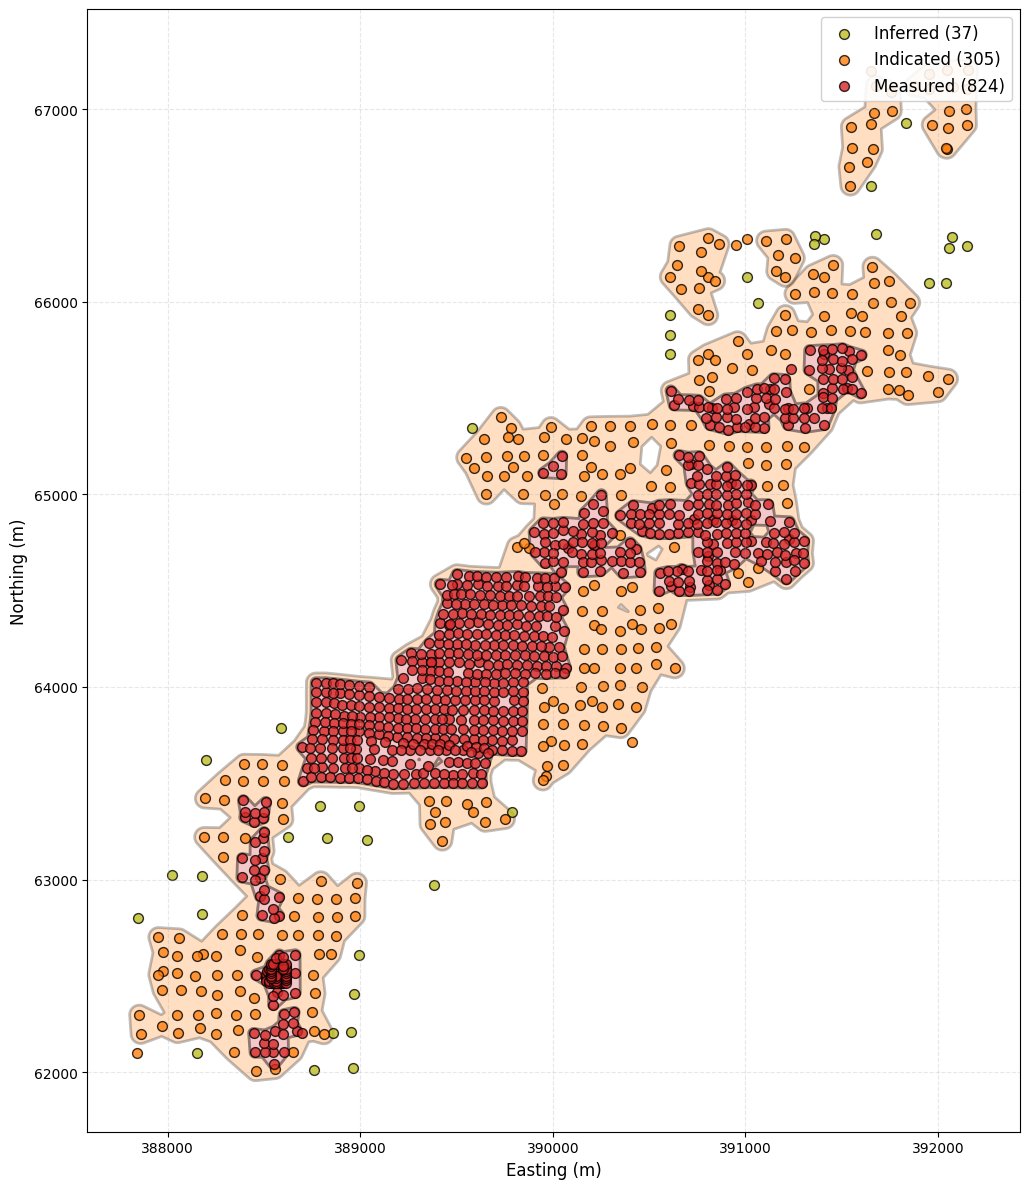


PARAMETER GUIDE:
CLUSTERING (controls which holes connect):
  area_factor: 0.4=strict, 0.6=balanced, 0.8=permissive
  edge_tolerance: 1.0=orthogonal only, 1.5=allow diagonals, 2.0=very loose

POLYGON BOUNDARY (alpha adapts to triangle constraints):
  measured_alpha: None=auto (recommended), or set manually
  indicated_alpha: None=auto (recommended), or set manually
  Auto alpha = max_edge × 0.6 × √area_factor
  Manual: smaller=tighter boundary, larger=smoother boundary


In [6]:
def calculate_nearest_neighbor_distances(points_gdf):
    """Calculate nearest neighbor distance for each drillhole"""
    from scipy.spatial import cKDTree
    
    coords = np.array(list(zip(points_gdf.geometry.x, points_gdf.geometry.y)))
    tree = cKDTree(coords)
    distances, indices = tree.query(coords, k=2)
    return distances[:, 1]

def calculate_triangle_area(p1, p2, p3):
    """Calculate area of a triangle given three points"""
    v1 = p2 - p1
    v2 = p3 - p1
    area = 0.5 * abs(np.cross(v1, v2))
    return area

def is_valid_triangle(p1, p2, p3, max_area, max_edge, edge_tolerance=1.5):
    """Check if triangle is valid based on area and edge constraints"""
    area = calculate_triangle_area(p1, p2, p3)
    if area > max_area:
        return False
    
    edge1 = np.linalg.norm(p2 - p1)
    edge2 = np.linalg.norm(p3 - p2)
    edge3 = np.linalg.norm(p1 - p3)
    edges = sorted([edge1, edge2, edge3])
    
    # At least 2 edges within limit, longest can be diagonal
    if edges[0] <= max_edge and edges[1] <= max_edge:
        if edges[2] <= max_edge * edge_tolerance:
            return True
    
    return False

def find_triangle_based_clusters(points_gdf, max_distance, max_area, min_drillholes=4, edge_tolerance=1.5):
    """Find clusters using triangle connectivity"""
    coords = np.array(list(zip(points_gdf.geometry.x, points_gdf.geometry.y)))
    n_points = len(coords)
    
    if n_points < min_drillholes:
        return np.full(n_points, -1)
    
    tri = Delaunay(coords)
    
    # Validate triangles
    valid_triangle_indices = []
    rejected_by_area = 0
    rejected_by_edge = 0
    
    for simplex in tri.simplices:
        p1, p2, p3 = coords[simplex]
        
        area = calculate_triangle_area(p1, p2, p3)
        if area > max_area:
            rejected_by_area += 1
            continue
        
        edge1 = np.linalg.norm(p2 - p1)
        edge2 = np.linalg.norm(p3 - p2)
        edge3 = np.linalg.norm(p1 - p3)
        edges = sorted([edge1, edge2, edge3])
        
        if edges[0] <= max_distance and edges[1] <= max_distance:
            if edges[2] <= max_distance * edge_tolerance:
                valid_triangle_indices.append(simplex)
            else:
                rejected_by_edge += 1
        else:
            rejected_by_edge += 1
    
    print(f"  Triangle validation: {len(valid_triangle_indices)}/{len(tri.simplices)} valid")
    print(f"    Rejected by area: {rejected_by_area}, Rejected by edge: {rejected_by_edge}")
    
    if not valid_triangle_indices:
        return np.full(n_points, -1)
    
    # Build adjacency from valid triangles
    adjacency = np.zeros((n_points, n_points), dtype=int)
    for simplex in valid_triangle_indices:
        adjacency[simplex[0], simplex[1]] = 1
        adjacency[simplex[1], simplex[0]] = 1
        adjacency[simplex[0], simplex[2]] = 1
        adjacency[simplex[2], simplex[0]] = 1
        adjacency[simplex[1], simplex[2]] = 1
        adjacency[simplex[2], simplex[1]] = 1
    
    # Find connected components
    graph = csr_matrix(adjacency)
    n_components, labels = connected_components(csgraph=graph, directed=False)
    
    # Filter by minimum size
    valid_labels = labels.copy()
    for cluster_id in range(n_components):
        if np.sum(labels == cluster_id) < min_drillholes:
            valid_labels[labels == cluster_id] = -1
    
    # Renumber
    unique_valid = np.unique(valid_labels[valid_labels >= 0])
    label_map = {old: new for new, old in enumerate(unique_valid)}
    label_map[-1] = -1
    final_labels = np.array([label_map[label] for label in valid_labels])
    
    return final_labels

def calculate_adaptive_alpha(max_distance, area_factor, edge_tolerance):
    """
    Calculate alpha radius that adapts to triangle constraints.
    
    Logic: If we limited triangles by area and edges, the circumradius 
    of the largest valid triangle gives us a good alpha.
    
    For a triangle at the limits:
    - Two edges = max_distance
    - One edge = max_distance × edge_tolerance
    - Area ≈ max_distance² × area_factor
    
    This ensures alpha shapes respects the same constraints.
    """
    # Estimate circumradius for triangle at constraint limits
    # For an equilateral triangle: R = edge / sqrt(3)
    # For our case, we use the diagonal edge as reference
    max_edge = max_distance * edge_tolerance
    
    # Circumradius is roughly proportional to edge length
    # Scale by area_factor to respect area constraint
    alpha = max_edge * 0.6 * np.sqrt(area_factor)
    
    return alpha
def alpha_shape(points, alpha_radius):
    """
    Create alpha shape using circumradius constraint.
    This is the MAIN polygon generator.
    
    Alpha radius controls boundary smoothness:
    - Should adapt to triangle constraints for consistency
    - Small alpha: Tight, concave boundary
    - Large alpha: Smooth, convex boundary
    """
    if len(points) < 3:
        return MultiPoint(points).convex_hull
    
    tri = Delaunay(points)
    
    def circumradius(p1, p2, p3):
        """Calculate circumradius of triangle"""
        a = np.linalg.norm(p2 - p1)
        b = np.linalg.norm(p3 - p2)
        c = np.linalg.norm(p1 - p3)
        area = 0.5 * abs(np.cross(p2 - p1, p3 - p1))
        if area < 1e-10:
            return float('inf')
        return (a * b * c) / (4.0 * area)
    
    # Filter triangles by circumradius
    valid_triangles = []
    for simplex in tri.simplices:
        p1, p2, p3 = points[simplex]
        r = circumradius(p1, p2, p3)
        
        # Keep triangles with circumradius <= alpha
        if r <= alpha_radius:
            triangle = Polygon([p1, p2, p3])
            valid_triangles.append(triangle)
    
    if not valid_triangles:
        # If alpha too restrictive, use convex hull
        return MultiPoint(points).convex_hull
    
    # Union all valid triangles
    alpha_poly = unary_union(valid_triangles)
    return alpha_poly

def classify_drillholes(drillholes, measured_distance=71, indicated_distance=121, 
                       min_drillholes=4, area_factor=0.6, edge_tolerance=1.5):
    """Classify drillholes using triangle-based clustering"""
    print("\n" + "="*70)
    print("STEP 1: CLASSIFYING DRILLHOLES (Triangle-Based Clustering)")
    print("="*70)
    print(f"Parameters: area_factor={area_factor}, edge_tolerance={edge_tolerance}")
    
    nn_distances = calculate_nearest_neighbor_distances(drillholes)
    drillholes['nn_distance'] = nn_distances
    
    # Initial classification
    drillholes['category'] = 'Inferred'
    drillholes.loc[nn_distances < indicated_distance, 'category'] = 'Indicated'
    drillholes.loc[nn_distances < measured_distance, 'category'] = 'Measured'
    
    print(f"\nInitial classification:")
    print(drillholes['category'].value_counts())
    
    # Initialize cluster columns for ALL drillholes
    drillholes['measured_cluster'] = -1
    drillholes['indicated_cluster'] = -1
    
    # Triangle clustering for Measured
    measured_mask = drillholes['category'] == 'Measured'
    
    if measured_mask.sum() >= min_drillholes:
        max_area = measured_distance ** 2 * area_factor
        print(f"\nMeasured constraints: area≤{max_area:.0f}m², edge≤{measured_distance}m, diagonal≤{measured_distance*edge_tolerance:.0f}m")
        
        measured_subset = drillholes[measured_mask].copy()
        measured_clusters = find_triangle_based_clusters(
            measured_subset, measured_distance, max_area, 
            min_drillholes, edge_tolerance
        )
        
        # Assign clusters back to original dataframe using index
        drillholes.loc[measured_mask, 'measured_cluster'] = measured_clusters
    
    # Triangle clustering for Indicated (includes Measured holes)
    indicated_mask = drillholes['category'].isin(['Measured', 'Indicated'])
    
    if indicated_mask.sum() >= min_drillholes:
        max_area = indicated_distance ** 2 * area_factor
        print(f"\nIndicated constraints: area≤{max_area:.0f}m², edge≤{indicated_distance}m, diagonal≤{indicated_distance*edge_tolerance:.0f}m")
        
        indicated_subset = drillholes[indicated_mask].copy()
        indicated_clusters = find_triangle_based_clusters(
            indicated_subset, indicated_distance, max_area, 
            min_drillholes, edge_tolerance
        )
        
        # Assign clusters back to original dataframe using index
        drillholes.loc[indicated_mask, 'indicated_cluster'] = indicated_clusters
    
    # Downgrade invalid clusters
    drillholes.loc[(drillholes['category'] == 'Measured') & (drillholes['measured_cluster'] == -1), 'category'] = 'Indicated'
    drillholes.loc[(drillholes['category'] == 'Indicated') & (drillholes['indicated_cluster'] == -1), 'category'] = 'Inferred'
    
    # Re-cluster Indicated after downgrade
    indicated_mask = drillholes['category'].isin(['Measured', 'Indicated'])
    if indicated_mask.sum() >= min_drillholes:
        max_area = indicated_distance ** 2 * area_factor
        indicated_subset = drillholes[indicated_mask].copy()
        indicated_clusters = find_triangle_based_clusters(
            indicated_subset, indicated_distance, max_area, 
            min_drillholes, edge_tolerance
        )
        drillholes.loc[indicated_mask, 'indicated_cluster'] = indicated_clusters
    
    drillholes.loc[(drillholes['category'] == 'Indicated') & (drillholes['indicated_cluster'] == -1), 'category'] = 'Inferred'
    
    print(f"\nFinal classification:")
    print(drillholes['category'].value_counts())
    
    n_m = len(drillholes[drillholes['measured_cluster'] >= 0]['measured_cluster'].unique())
    n_i = len(drillholes[drillholes['indicated_cluster'] >= 0]['indicated_cluster'].unique())
    print(f"\nClusters: Measured={n_m}, Indicated={n_i}")
    
    return drillholes

def generate_alpha_shape_polygons(drillholes, measured_distance, indicated_distance,
                                  area_factor, edge_tolerance,
                                  measured_alpha=None, indicated_alpha=None,
                                  measured_buffer=25, indicated_buffer=50):
    """
    Generate polygons using alpha shapes that adapt to triangle constraints.
    If alpha not specified, automatically calculated from triangle parameters.
    """
    print("\n" + "="*70)
    print("STEP 2: GENERATING ALPHA SHAPE POLYGONS")
    print("="*70)
    
    all_polygons = []
    
    # Process Measured
    measured_valid = drillholes[drillholes['measured_cluster'] >= 0].copy()
    
    if len(measured_valid) > 0:
        # Auto-calculate alpha from triangle constraints if not specified
        if measured_alpha is None:
            measured_alpha = calculate_adaptive_alpha(measured_distance, area_factor, edge_tolerance)
            print(f"\nMeasured: Auto-calculated alpha = {measured_alpha:.1f}m (from triangle constraints)")
        else:
            print(f"\nMeasured: Manual alpha = {measured_alpha:.1f}m")
        
        print(f"  {len(measured_valid)} drillholes, buffer={measured_buffer}m")
        
        for cluster_id in measured_valid['measured_cluster'].unique():
            if cluster_id < 0:
                continue
                
            cluster_holes = measured_valid[measured_valid['measured_cluster'] == cluster_id]
            coords = np.array(list(zip(cluster_holes.geometry.x, cluster_holes.geometry.y)))
            
            # Alpha shape generates the polygon
            alpha_poly = alpha_shape(coords, measured_alpha)
            buffered_poly = alpha_poly.buffer(measured_buffer)
            
            all_polygons.append({
                'geometry': buffered_poly,
                'category': 'Measured',
                'cluster_id': int(cluster_id),
                'drillholes': len(cluster_holes)
            })
    
    # Process Indicated
    indicated_valid = drillholes[drillholes['indicated_cluster'] >= 0].copy()
    
    if len(indicated_valid) > 0:
        # Auto-calculate alpha from triangle constraints if not specified
        if indicated_alpha is None:
            indicated_alpha = calculate_adaptive_alpha(indicated_distance, area_factor, edge_tolerance)
            print(f"\nIndicated: Auto-calculated alpha = {indicated_alpha:.1f}m (from triangle constraints)")
        else:
            print(f"\nIndicated: Manual alpha = {indicated_alpha:.1f}m")
        
        print(f"  {len(indicated_valid)} drillholes, buffer={indicated_buffer}m")
        
        measured_geoms = [p['geometry'] for p in all_polygons if p['category'] == 'Measured']
        measured_union = unary_union(measured_geoms) if measured_geoms else None
        
        for cluster_id in indicated_valid['indicated_cluster'].unique():
            if cluster_id < 0:
                continue
                
            cluster_holes = indicated_valid[indicated_valid['indicated_cluster'] == cluster_id]
            coords = np.array(list(zip(cluster_holes.geometry.x, cluster_holes.geometry.y)))
            
            # Alpha shape generates the polygon
            alpha_poly = alpha_shape(coords, indicated_alpha)
            buffered_poly = alpha_poly.buffer(indicated_buffer)
            
            if measured_union:
                buffered_poly = buffered_poly.difference(measured_union)
            
            if not buffered_poly.is_empty:
                all_polygons.append({
                    'geometry': buffered_poly,
                    'category': 'Indicated',
                    'cluster_id': int(cluster_id),
                    'drillholes': len(cluster_holes)
                })
    
    if not all_polygons:
        return gpd.GeoDataFrame()
    
    result_gdf = gpd.GeoDataFrame(all_polygons, crs=drillholes.crs)
    result_gdf['area_m2'] = result_gdf.geometry.area
    result_gdf['area_ha'] = result_gdf['area_m2'] / 10000
    
    print(f"\nGenerated {len(result_gdf)} polygon(s): Measured={len(result_gdf[result_gdf['category']=='Measured'])}, Indicated={len(result_gdf[result_gdf['category']=='Indicated'])}")
    
    return result_gdf

def generate_resource_polygons(gpkg_path, output_path=None,
                               measured_distance=71, indicated_distance=121,
                               measured_alpha=None, indicated_alpha=None,
                               measured_buffer=25, indicated_buffer=50,
                               min_drillholes=4, area_factor=0.6, edge_tolerance=1.5):
    """
    Generate resource polygons:
    1. Triangle-based clustering (uses area_factor, edge_tolerance)
    2. Alpha shape polygons (uses alpha radius for boundary)
    
    Parameters:
    -----------
    area_factor : float
        Triangle area = distance² × area_factor (clustering)
        Smaller (0.4) = restrictive, Larger (0.8) = permissive
    edge_tolerance : float  
        Diagonal tolerance (clustering)
        1.0 = no diagonals, 1.5 = allow √2, 2.0 = very permissive
    measured_alpha : float
        Alpha radius for Measured polygons (boundary smoothness)
        Smaller = tight boundary, Larger = smooth boundary
        Default = median spacing × 0.7
    indicated_alpha : float
        Alpha radius for Indicated polygons
    """
    print("="*70)
    print("TRIANGLE CLUSTERING + ALPHA SHAPE POLYGONS")
    print("="*70)
    print(f"Reading: {gpkg_path}")
    
    drillholes = gpd.read_file(gpkg_path)
    print(f"Loaded: {len(drillholes)} drillholes, CRS: {drillholes.crs}")
    
    # Step 1: Triangle-based clustering
    classified = classify_drillholes(
        drillholes, measured_distance, indicated_distance,
        min_drillholes, area_factor, edge_tolerance
    )
    
    # Step 2: Alpha shape polygon generation (adapts to triangle constraints)
    result_gdf = generate_alpha_shape_polygons(
        classified, measured_distance, indicated_distance,
        area_factor, edge_tolerance,
        measured_alpha, indicated_alpha,
        measured_buffer, indicated_buffer
    )
    
    # Save
    if output_path and not result_gdf.empty:
        print(f"\nSaving: {output_path}")
        result_gdf.to_file(output_path, driver='GPKG')
        
        drill_out = output_path.replace('.gpkg', '_drillholes.gpkg')
        classified.to_file(drill_out, driver='GPKG')
        print(f"Drillholes: {drill_out}")
    
    # Plot
    if not result_gdf.empty:
        plot_results(classified, result_gdf)
    
    return result_gdf, classified

def plot_results(drillholes, polygons):
    """Clean single-map visualization"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 12))
    
    # Plot polygons
    colors_poly = {'Measured': '#d62728', 'Indicated': '#ff7f0e'}
    
    for category in ['Indicated', 'Measured']:
        cat_polys = polygons[polygons['category'] == category]
        if len(cat_polys) > 0:
            cat_polys.plot(ax=ax, color=colors_poly[category], 
                          alpha=0.25, edgecolor='black', linewidth=2)
    
    # Plot drillholes
    colors_dh = {'Measured': '#d62728', 'Indicated': '#ff7f0e', 'Inferred': '#bcbd22'}
    
    for category in ['Inferred', 'Indicated', 'Measured']:
        subset = drillholes[drillholes['category'] == category]
        if len(subset) > 0:
            subset.plot(ax=ax, color=colors_dh[category], markersize=50,
                       alpha=0.8, edgecolor='black', linewidth=1,
                       label=f'{category} ({len(subset)})')
    
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
    ax.set_xlabel('Easting (m)', fontsize=12)
    ax.set_ylabel('Northing (m)', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('resource_map.png', dpi=300, bbox_inches='tight')
    print("\nMap: resource_map.png")
    plt.show()

# Example usage
if __name__ == "__main__":
    result, classified = generate_resource_polygons(
        gpkg_path="drillhole/test_1.gpkg",
        output_path="test_output/alpha_r=36_61_af=06_et=16.gpkg",
        
        # Clustering parameters
        measured_distance=71,
        indicated_distance=121,
        min_drillholes=4,
        area_factor=0.6,           # 0.4=restrictive, 0.8=permissive
        edge_tolerance=1.6,        # 1.0=no diagonals, 1.5=allow √2
        
        # Polygon generation parameters  
        measured_alpha=None,       # Auto: median_spacing × 0.7
        indicated_alpha=None,      # Auto: median_spacing × 0.7
        measured_buffer=25,
        indicated_buffer=50
    )
    
    print("\n" + "="*70)
    print("PARAMETER GUIDE:")
    print("="*70)
    print("CLUSTERING (controls which holes connect):")
    print("  area_factor: 0.4=strict, 0.6=balanced, 0.8=permissive")
    print("  edge_tolerance: 1.0=orthogonal only, 1.5=allow diagonals, 2.0=very loose")
    print("\nPOLYGON BOUNDARY (alpha adapts to triangle constraints):")
    print("  measured_alpha: None=auto (recommended), or set manually")
    print("  indicated_alpha: None=auto (recommended), or set manually")
    print("  Auto alpha = max_edge × 0.6 × √area_factor")
    print("  Manual: smaller=tighter boundary, larger=smoother boundary")
    print("="*70)